In [1]:
from statsbombpy import sb

wc_matches = sb.matches(competition_id=43, season_id=106)

wc_final = wc_matches[
    (wc_matches["home_team"] == "Argentina") |
    (wc_matches["away_team"] == "Argentina")
].sort_values("match_date")

wc_final[["match_id", "home_team", "away_team", "match_date"]]


c:\Users\Βασιλης\statsbomb_project\.venv\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,match_id,home_team,away_team,match_date
37,3857300,Argentina,Saudi Arabia,2022-11-22
13,3857289,Argentina,Mexico,2022-11-26
11,3857264,Poland,Argentina,2022-11-30
1,3869151,Argentina,Australia,2022-12-03
6,3869321,Netherlands,Argentina,2022-12-09
19,3869519,Argentina,Croatia,2022-12-13
9,3869685,Argentina,France,2022-12-18


In [2]:
final_match_id = 3869685
events_final = sb.events(match_id=final_match_id)
events_final.shape

c:\Users\Βασιλης\statsbomb_project\.venv\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


(4407, 94)

In [3]:
lineups = sb.lineups(match_id=final_match_id)

c:\Users\Βασιλης\statsbomb_project\.venv\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [4]:
arg_lineup = lineups["Argentina"]
arg_lineup.head()


,player_id,player_name,player_nickname,jersey_number,country,cards,positions
0,2995,Ángel Fabián Di María Hernández,Ángel Di María,11,Argentina,[],"[{'position_id': 21, 'position': 'Left Wing', ..."
1,3090,Nicolás Hernán Otamendi,Nicolás Otamendi,19,Argentina,[],"[{'position_id': 5, 'position': 'Left Center B..."
2,5503,Lionel Andrés Messi Cuccittini,Lionel Messi,10,Argentina,[],"[{'position_id': 17, 'position': 'Right Wing',..."
3,5507,Nicolás Alejandro Tagliafico,Nicolás Tagliafico,3,Argentina,[],"[{'position_id': 6, 'position': 'Left Back', '..."
4,5743,Paulo Bruno Exequiel Dybala,Paulo Dybala,21,Argentina,[],"[{'position_id': 8, 'position': 'Left Wing Bac..."


In [5]:
shirt_map = (
    arg_lineup[["player_name", "jersey_number"]]
    .set_index("player_name")["jersey_number"]
    .to_dict()
)


In [6]:
passes = events_final[
    (events_final["type"] == "Pass") &
    (events_final["pass_outcome"].isna())
]


Passing network

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
from mplsoccer import Pitch
import ast

Last try

In [9]:
TEAM = "Argentina"

passes = events_final[
    (events_final["type"] == "Pass") &
    (events_final["team"] == TEAM) &
    (events_final["pass_outcome"].isna())
].copy()

passes.shape


(560, 94)

In [10]:
def to_xy(v):
    if isinstance(v, (list, tuple)) and len(v) >= 2:
        return v[0], v[1]
    if isinstance(v, str):
        try:
            vv = ast.literal_eval(v)
            if isinstance(vv, (list, tuple)) and len(vv) >= 2:
                return vv[0], vv[1]
        except Exception:
            pass
    return np.nan, np.nan


In [11]:
passes[["x", "y"]] = passes["location"].apply(lambda v: pd.Series(to_xy(v)))
passes[["end_x", "end_y"]] = passes["pass_end_location"].apply(lambda v: pd.Series(to_xy(v)))

passes = passes.dropna(
    subset=["x", "y", "end_x", "end_y", "player", "pass_recipient"]
)

passes.shape


(560, 98)

In [12]:
def pass_type_name(v):
    if isinstance(v, dict):
        return v.get("name")
    if isinstance(v, str):
        try:
            d = ast.literal_eval(v)
            if isinstance(d, dict):
                return d.get("name")
        except Exception:
            return v
        return v
    return None

passes["pass_type_name"] = passes["pass_type"].apply(pass_type_name)

SET_PIECES = {"Corner", "Free Kick", "Kick Off", "Throw-in", "Goal Kick"}

passes = passes[~passes["pass_type_name"].isin(SET_PIECES)].copy()
passes.shape


(514, 99)

In [13]:
player_pos = (
    passes
    .groupby("player")
    .agg(
        avg_x=("x", "mean"),
        avg_y=("y", "mean"),
        pass_count=("x", "count")
    )
    .reset_index()
)

# remove fringe players
MIN_PASSES = 10
player_pos = player_pos[player_pos["pass_count"] >= MIN_PASSES].copy()
player_pos.shape


(13, 4)

In [14]:
keep_players = set(player_pos["player"])

passes = passes[
    passes["player"].isin(keep_players) &
    passes["pass_recipient"].isin(keep_players)
].copy()


In [79]:
passes_total = (
    passes
    .groupby(["player"])
    .size()
    .reset_index(name="pass_count")
)

In [81]:
passes_total.sort_values("pass_count", ascending=False)

,player,pass_count
3,Enzo Fernandez,71
10,Nicolás Hernán Otamendi,65
1,Cristian Gabriel Romero,55
11,Rodrigo Javier De Paul,54
0,Alexis Mac Allister,44
6,Lionel Andrés Messi Cuccittini,42
9,Nicolás Alejandro Tagliafico,37
8,Nahuel Molina Lucero,28
4,Julián Álvarez,25
12,Ángel Fabián Di María Hernández,21


In [15]:
edges = (
    passes
    .groupby(["player", "pass_recipient"])
    .size()
    .reset_index(name="pass_count")
)

edges = edges[edges["pass_count"] >= 3].copy()
edges.sort_values("pass_count", ascending=False).head()


,player,pass_recipient,pass_count
80,Nicolás Hernán Otamendi,Cristian Gabriel Romero,18
86,Nicolás Hernán Otamendi,Nicolás Alejandro Tagliafico,14
33,Enzo Fernandez,Rodrigo Javier De Paul,14
94,Rodrigo Javier De Paul,Lionel Andrés Messi Cuccittini,14
82,Nicolás Hernán Otamendi,Enzo Fernandez,13


In [84]:
edges[edges["pass_count"] >= 10]

,player,pass_recipient,pass_count
0,Alexis Mac Allister,Enzo Fernandez,12
11,Cristian Gabriel Romero,Enzo Fernandez,13
15,Cristian Gabriel Romero,Nicolás Hernán Otamendi,12
16,Cristian Gabriel Romero,Rodrigo Javier De Paul,11
28,Enzo Fernandez,Lionel Andrés Messi Cuccittini,11
33,Enzo Fernandez,Rodrigo Javier De Paul,14
56,Lionel Andrés Messi Cuccittini,Rodrigo Javier De Paul,12
72,Nahuel Molina Lucero,Rodrigo Javier De Paul,10
73,Nicolás Alejandro Tagliafico,Alexis Mac Allister,11
80,Nicolás Hernán Otamendi,Cristian Gabriel Romero,18


In [83]:
edges.sort_values("pass_count", ascending=False)

,player,pass_recipient,pass_count
80,Nicolás Hernán Otamendi,Cristian Gabriel Romero,18
86,Nicolás Hernán Otamendi,Nicolás Alejandro Tagliafico,14
33,Enzo Fernandez,Rodrigo Javier De Paul,14
94,Rodrigo Javier De Paul,Lionel Andrés Messi Cuccittini,14
82,Nicolás Hernán Otamendi,Enzo Fernandez,13
...,...,...,...
84,Nicolás Hernán Otamendi,Marcos Javier Acuña,3
89,Rodrigo Javier De Paul,Alexis Mac Allister,3
87,Nicolás Hernán Otamendi,Rodrigo Javier De Paul,3
98,Ángel Fabián Di María Hernández,Alexis Mac Allister,3


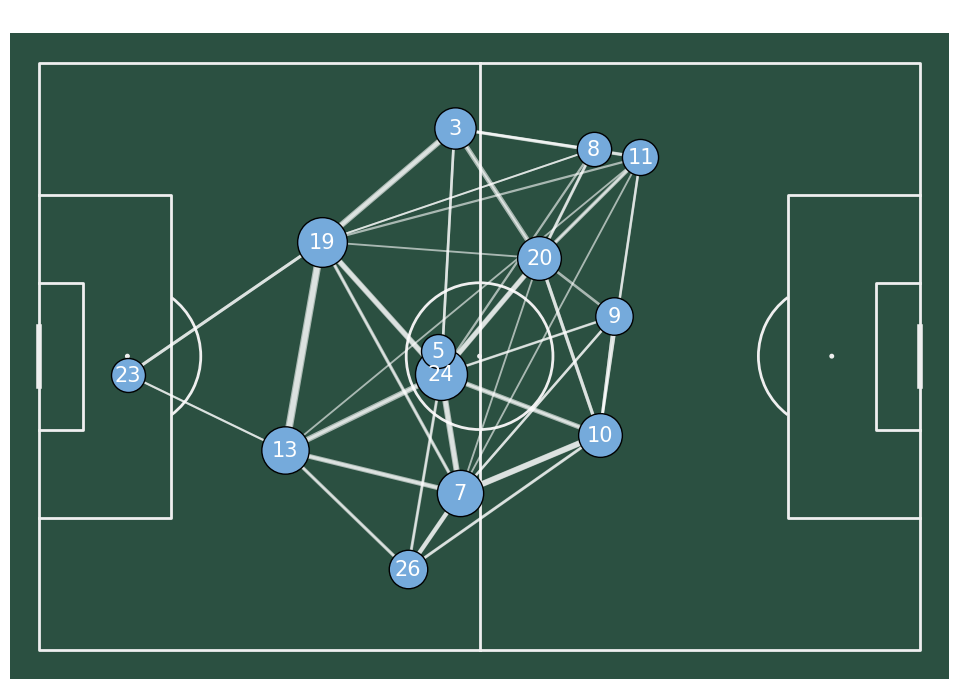

In [16]:
pitch = Pitch(
    pitch_type="statsbomb",
    pitch_color="#2b5041",
    line_color="#efefef"
)

fig, ax = pitch.draw(figsize=(11, 7))


pos_map = {
    r["player"]: (r["avg_x"], r["avg_y"])
    for _, r in player_pos.iterrows()
}

max_edge = edges["pass_count"].max()

for _, r in edges.iterrows():
    p1, p2, w = r["player"], r["pass_recipient"], r["pass_count"]
    x1, y1 = pos_map[p1]
    x2, y2 = pos_map[p2]

    lw = 0.5 + 5 * (w / max_edge)

    pitch.lines(
        x1, y1, x2, y2,
        lw=lw,
        color="white",
        alpha=0.6,
        ax=ax
    )
max_node = player_pos["pass_count"].max()

for _, r in player_pos.iterrows():
    x, y = r["avg_x"], r["avg_y"]
    size = 400 + 1000 * (r["pass_count"] / max_node)

    pitch.scatter(
        x, y,
        s=size,
        color="#75AADB",
        edgecolors="black",
        linewidth=1,
        ax=ax,
        zorder=3
    )

    ax.text(
        x, y,
        shirt_map[r['player']],
        ha="center",
        va="center",
        fontsize=15,
        color="#FFFFFF",
        zorder=4
    )
    ax.set_title(
        "Argentina Passing Network — World Cup 2022 Final (Whole Match)",
        fontsize=16,
        color="white"
    )



Shot map

In [30]:
TEAM = "France"

shots = events_final[
    (events_final["type"] == "Shot") &
    (events_final["team"] == TEAM)
].copy()

shots.shape


(14, 94)

In [31]:
def to_xy(v):
    if isinstance(v, (list, tuple)) and len(v) >= 2:
        return v[0], v[1]
    if isinstance(v, str):
        try:
            vv = ast.literal_eval(v)
            if isinstance(vv, (list, tuple)) and len(vv) >= 2:
                return vv[0], vv[1]
        except Exception:
            pass
    return np.nan, np.nan


In [32]:
shots[["x", "y"]] = shots["location"].apply(lambda v: pd.Series(to_xy(v)))
shots = shots.dropna(subset=["x", "y"])


In [33]:
shots["is_goal"] = shots["shot_outcome"] == "Goal"
shots["xg"] = shots["shot_statsbomb_xg"].fillna(0)


In [41]:
shots[["player", "xg", "shot_outcome"]]


,player,xg,shot_outcome
4216,Randal Kolo Muani,0.096184,Off T
4217,Kylian Mbappé Lottin,0.050644,Off T
4219,Kylian Mbappé Lottin,0.783500,Goal
4220,Kylian Mbappé Lottin,0.101703,Goal
4222,Kylian Mbappé Lottin,0.032449,Blocked
4223,Adrien Rabiot,0.093335,Saved
4226,Youssouf Fofana,0.023032,Blocked
4233,Kylian Mbappé Lottin,0.030757,Blocked
4234,Kylian Mbappé Lottin,0.783500,Goal
4235,Randal Kolo Muani,0.277514,Saved


In [52]:
shots[shots["xg"] == 0.27751]

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,...,tactics,team,team_id,timestamp,type,under_pressure,x,y,is_goal,xg


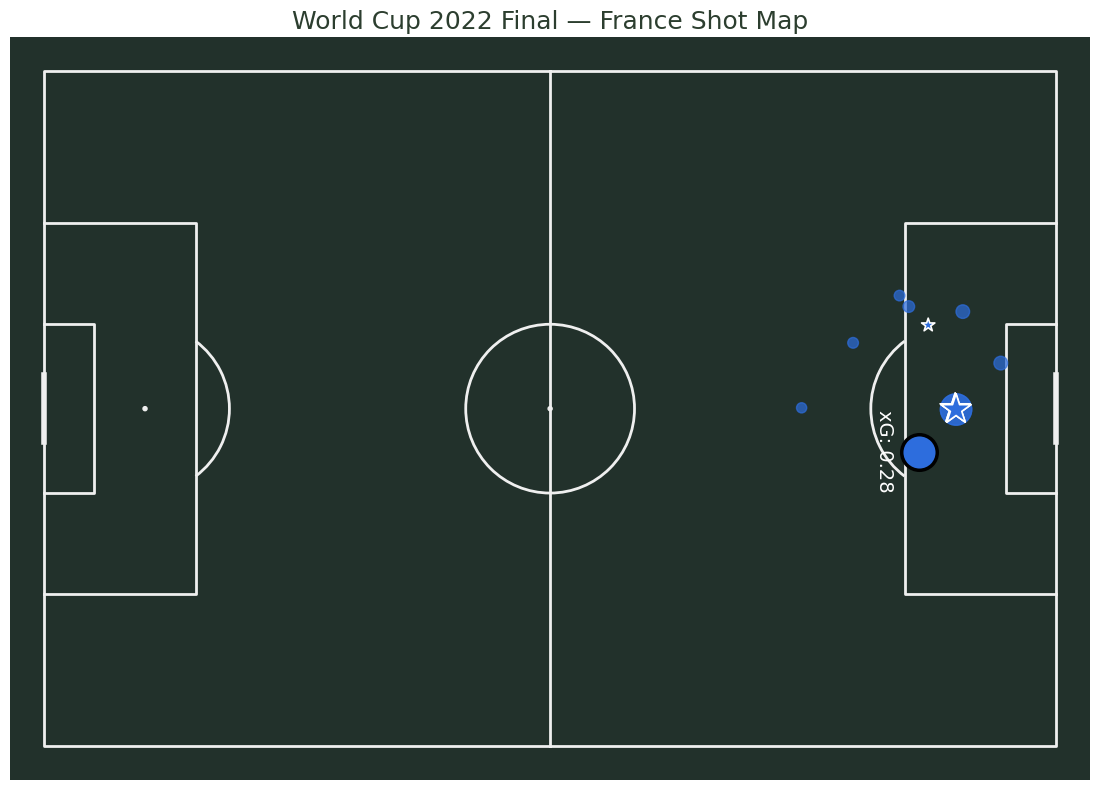

In [75]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# --- Pitch ---
pitch = Pitch(
    pitch_type="statsbomb",
    pitch_color="#22312b",
    line_color="#efefef"
)

fig, ax = pitch.draw(figsize=(12, 8))

# --- Marker sizes ---
sizes = shots["xg"] * 600 + 40

# --- Non-goals ---
pitch.scatter(
    shots.loc[~shots["is_goal"], "x"],
    shots.loc[~shots["is_goal"], "y"],
    s=sizes.loc[~shots["is_goal"]],
    color="#2d6ddd",
    alpha=0.7,
    ax=ax,
    zorder=2
)

# --- Goals (stars) ---
pitch.scatter(
    shots.loc[shots["is_goal"], "x"],
    shots.loc[shots["is_goal"], "y"],
    s=sizes.loc[shots["is_goal"]],
    marker="*",
    color="#2d6ddd",
    edgecolors="white",
    linewidth=1.2,
    ax=ax,
    zorder=3
)

# --- Highlight Kolo Muani missed shot (event_id = 4235) ---
highlight = shots[
    (shots["player"] == "Randal Kolo Muani") &
    (shots["shot_outcome"] != "Goal") &
    (shots["xg"].between(0.26, 0.29))
]


pitch.scatter(
    highlight["x"],
    highlight["y"],
    s=highlight["xg"] * 2000 + 100,
    color="#2d6ddd",
    edgecolors="black",
    linewidth=2.5,
    alpha=1.0,
    ax=ax,
    zorder=4
)

# --- Annotation ---
row = highlight.iloc[0]
ax.text(
    row["x"] - 3,
    row["y"] ,
    "xG: 0.28",
    ha="center",
    va="top",
    rotation=270,
    rotation_mode="anchor",
    fontsize=14,
    color="white",
    zorder=8
)

# --- Title ---
ax.set_title(
    "World Cup 2022 Final — France Shot Map",
    fontsize=18,
    color="#2c3e2f"
)

plt.show()


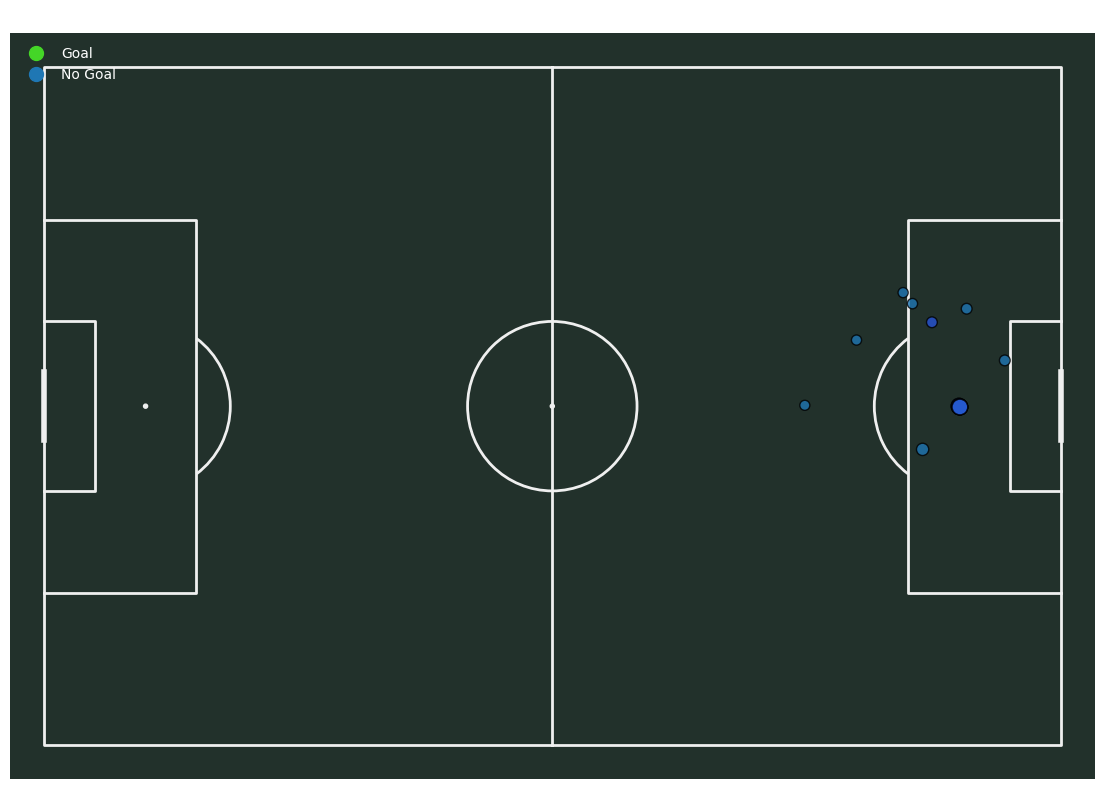

In [35]:
pitch = Pitch(
    pitch_type="statsbomb",
    pitch_color="#22312b",
    line_color="#efefef"
)

fig, ax = pitch.draw(figsize=(12, 8))

# Scale marker size by xG
sizes = shots["xg"] * 100 + 50

# Colors
colors = shots["is_goal"].map({True: "#2753d6", False: "#1f77b4"})

pitch.scatter(
    shots["x"],
    shots["y"],
    s=sizes,
    c=colors,
    edgecolors="black",
    alpha=0.8,
    ax=ax,
    zorder=3
)

ax.set_title(
    "Argentina Shot Map — World Cup 2022 Final",
    fontsize=16,
    color="white"
)

# Manual legend
ax.scatter([], [], c="#44d627", s=100, label="Goal")
ax.scatter([], [], c="#1f77b4", s=100, label="No Goal")

ax.legend(
    loc="upper left",
    frameon=False,
    labelcolor="white"
)



In [22]:
import mplcursors

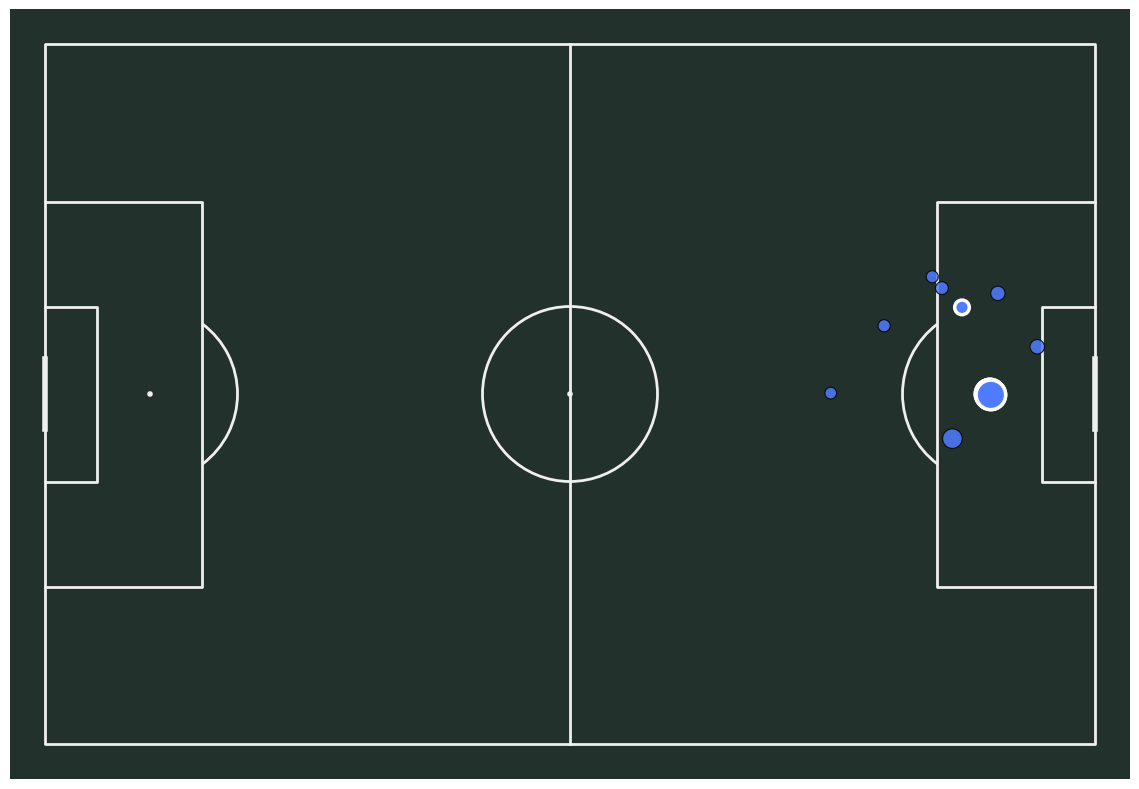

In [39]:
pitch = Pitch(
    pitch_type="statsbomb",
    pitch_color="#22312b",
    line_color="#efefef"
)

fig, ax = pitch.draw(figsize=(12, 8))

sizes = shots["xg"] * 500 + 60

shots_goal = shots[shots["is_goal"]].copy()
shots_nongoal = shots[~shots["is_goal"]].copy()

sc_nongoal = pitch.scatter(
    shots_nongoal["x"],
    shots_nongoal["y"],
    s=sizes.loc[shots_nongoal.index],
    color="#4f7cff",          # single calm blue
    edgecolors="black",
    linewidth=0.8,
    alpha=0.85,
    ax=ax,
    zorder=3
)

sc_goal = pitch.scatter(
    shots_goal["x"],
    shots_goal["y"],
    s=sizes.loc[shots_goal.index],
    color="#4f7cff",          # SAME color
    edgecolors="white",
    linewidth=2.5,            # thick outline
    alpha=1.0,
    ax=ax,
    zorder=4
)




In [24]:
shots_goal = shots[shots["is_goal"]].copy()
shots_nongoal = shots[~shots["is_goal"]].copy()


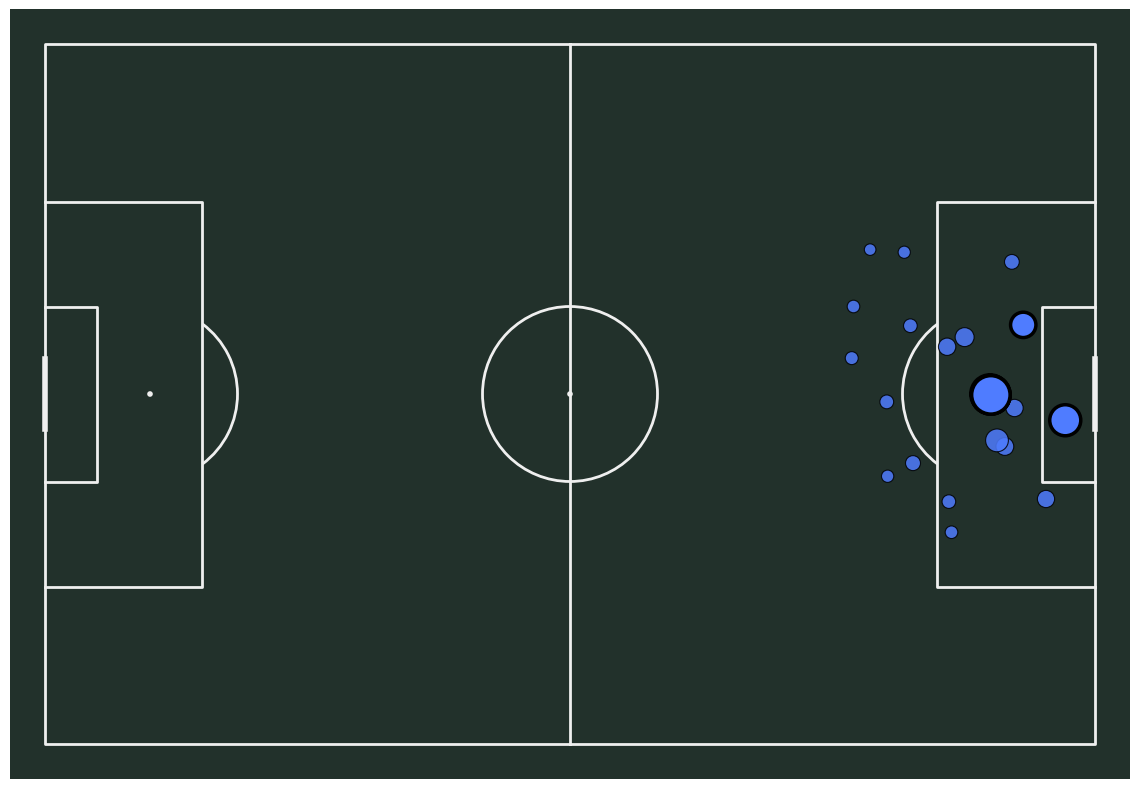

In [26]:
pitch = Pitch(
    pitch_type="statsbomb",
    pitch_color="#22312b",
    line_color="#efefef"
)

fig, ax = pitch.draw(figsize=(12, 8))

sizes = shots["xg"] * 900 + 60

sc_nongoal = pitch.scatter(
    shots_nongoal["x"],
    shots_nongoal["y"],
    s=(shots_nongoal["xg"] * 900 + 60),
    color="#4f7cff",
    edgecolors="black",
    linewidth=0.8,
    alpha=0.85,
    ax=ax,
    zorder=3
)

sc_goal = pitch.scatter(
    shots_goal["x"],
    shots_goal["y"],
    s=(shots_goal["xg"] * 900 + 60),
    color="#4f7cff",
    edgecolors="black",
    linewidth=2.5,
    alpha=1.0,
    ax=ax,
    zorder=4
)


cursor = mplcursors.cursor([sc_nongoal, sc_goal], hover=True)

@cursor.connect("add")
def on_add(sel):
    artist = sel.artist
    idx = sel.index

    if artist is sc_nongoal:
        row = shots_nongoal.iloc[idx]
    elif artist is sc_goal:
        row = shots_goal.iloc[idx]
    else:
        return

    sel.annotation.set_text(
        f"{row['player']}\n"
        f"xG: {row['xg']:.2f}"
    )

    sel.annotation.get_bbox_patch().set(
        fc="#111111", alpha=0.9
    )
    sel.annotation.get_text().set(color="white")
